In [46]:
import tensorflow as tf
print("version :",tf.__version__)

version : 2.15.0


In [47]:
dset = tf.keras.datasets.cifar10
(X_train,y_train),(X_test,y_test) = dset.load_data()

In [14]:
print(X_train.shape,X_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


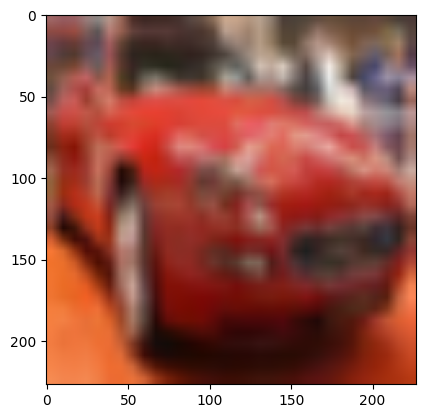

In [48]:
# 논문에서 227x227로 size transformation 진행 (논문 데이터는 256x256 크기여서 crop)
# 여기서 img size = 32x32 , y_train은 0~9까지 총 10개
# size 227x227로 변환하기, 0~1 사이로 픽셀값 변경위해 255로 나누기

import matplotlib.pyplot as plt
# resize
image = X_train[5]
test_img = tf.image.resize(image,(227,227))
# divide 255
test_img_np = test_img.numpy() / 255
plt.imshow(test_img_np)

In [49]:
# CIFAR 10 모든 이미지에 대하여 resize 진행

def image_transform(img,cls):
    img = tf.image.resize(img,(227,227))
    return img,cls

cls= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))

train_ds = train_ds.map(image_transform)
test_ds = test_ds.map(image_transform)

In [51]:
# Model
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization

class AlexNet_Model(keras.Sequential):
    def __init__(self):
        super().__init__()

        # First Layer

        # 96 kernels of size 11x11x3, 4 strides
        # relu 적용, LRN 대신 batch normalization 적용
        # 2개의 gpu 사용이니 48 로 2개 하는건가...?
        self.add(Conv2D(96,11,strides=4,activation = 'relu',input_shape = (227,227,3)))
        self.add(BatchNormalization())
        # 출력 맵 크기 = (227-11)/4 +1 = 55 --> 55x55x96으로 변환
        self.add(MaxPooling2D(3,2))
        # 3x3씩 stride=2로 진행하면 27x27x96으로 변환

        # Second Layer
        self.add(Conv2D(256, 5, strides=1, activation='relu', padding='same'))
        # padding='same'이므로 크기 변환 없음. 27x27x256으로 변환
        # pytorch면 padding=2로 하면 될거같음
        self.add(BatchNormalization())
        self.add(MaxPooling2D(3, 2))
        # Maxpooling 진헹시 13x13x256

        # Third, Fourth, Fifth
        self.add(Conv2D(384,3,strides=1,activation='relu',padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(384,3,strides=1,activation='relu',padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(256,3,strides=1,activation='relu',padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPooling2D(3,2))
        # 현재 6x6x256
        # 이후 flatten 하고 cifar10의 y는 10이므로 10개로 softmax 진행

        self.add(Flatten())
        self.add(Dense(4096,activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(4096,activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(10,activation='softmax'))

model = AlexNet_Model()
model.summary()

Model: "alex_net__model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                 

In [52]:
from keras.optimizers import Adam

# 논문은 Stochastic Gradient Descent(SGD)
model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [53]:
from keras.callbacks import ReduceLROnPlateau
# 손실이 감소하지않을 때 learning rate 를 변동시켜줄 수 있음
# min_lr (학습률 감소할 최소 값), 3회동안 val_loss 향상 안되면 lr을 0.2 곱하겠다
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)


In [58]:
# batch_size=64로 진행
batch_size = 64
train_ds = train_ds.batch(batch_size=batch_size)
test_ds = test_ds.batch(batch_size=batch_size)

In [59]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
782/782 [==============================] - 85s 93ms/step - loss: 3.3796 - accuracy: 0.3015 - val_loss: 1.6303 - val_accuracy: 0.4135
Epoch 2/10
782/782 [==============================] - 73s 93ms/step - loss: 1.6567 - accuracy: 0.4139 - val_loss: 1.4505 - val_accuracy: 0.4642
Epoch 3/10
782/782 [==============================] - 76s 98ms/step - loss: 1.4947 - accuracy: 0.4795 - val_loss: 1.3570 - val_accuracy: 0.5430
Epoch 4/10
782/782 [==============================] - 73s 93ms/step - loss: 1.3536 - accuracy: 0.5366 - val_loss: 1.2579 - val_accuracy: 0.5590
Epoch 5/10
782/782 [==============================] - 76s 98ms/step - loss: 1.2076 - accuracy: 0.5889 - val_loss: 1.3346 - val_accuracy: 0.5517
Epoch 6/10
782/782 [==============================] - 77s 98ms/step - loss: 1.0750 - accuracy: 0.6390 - val_loss: 1.1296 - val_accuracy: 0.6059
Epoch 7/10
782/782 [==============================] - 72s 92ms/step - loss: 0.9390 - accuracy: 0.6853 - val_loss: 1.0609 - val_accuracy:

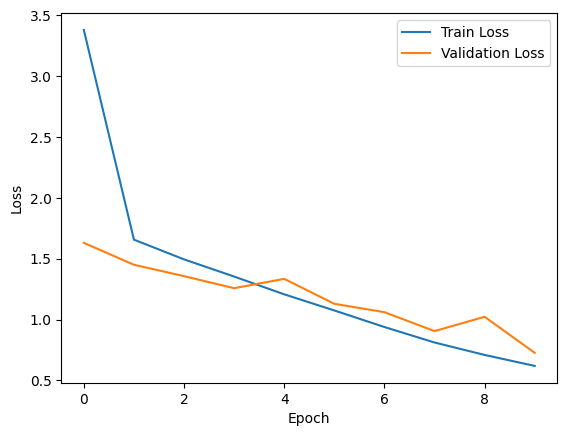

In [61]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

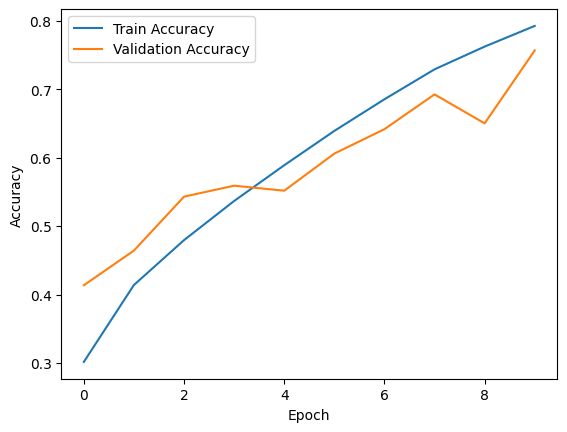

In [62]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()